In [25]:
import pygad
import numpy
import matplotlib.pyplot as plt
import os
import wntr

def change_emitter_inp():
    with open('Real_Synthetic_Artificial_leak_N6.inp','r') as file:
        content = file.read().split('\n')
        #find the '[EMITTERS]' in content
        index = content.index('[EMITTERS]')
        coefficient = float(content[index+2].split()[1])
        file.close()
    return coefficient
        
change_emitter_inp()

0.5

In [43]:
print(open('Real_Synthetic_Artificial_leak_N6.inp','r').read())

[TITLE]


[JUNCTIONS]
;ID              	Elev        	Demand      	Pattern         
 N1              	25          	1           	                	;
 N5              	10          	13          	                	;
 N10             	5           	1.2         	                	;
 N7              	5           	1.21        	                	;
 N2              	9           	12.6        	                	;
 N6              	7           	10.1        	                	;
 N3              	6           	1.1         	                	;
 N8              	6           	23          	                	;
 N13             	0           	1.7         	                	;
 N9              	7           	3.9         	                	;
 N14             	6           	1.5         	                	;
 N4              	4           	1.2         	                	;
 N11             	6           	1.5         	                	;
 N12             	6           	1.2         	                	;
 N15             	5           	0.89

<AxesSubplot:title={'center':'Pressure at 0 hours'}>

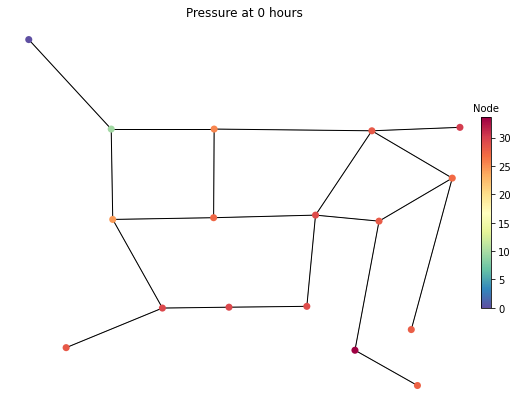

In [26]:
wn = wntr.network.WaterNetworkModel('Real_Synthetic_Artificial_leak_N6.inp')
sim = wntr.sim.WNTRSimulator(wn)
junction = wn.get_node('N8') # Variable "junction" is associated to N8
junction.demand_timeseries_list[0].base_value = 0 # Demand is changed in N8
results = sim.run_sim()  # The new Epanet model is launched
pressure_at_0hr = results.node['pressure'].loc[0, :]  # New pressures are stored

plt.rcParams['figure.figsize'] = (10,7)
wntr.graphics.plot_network(wn, node_attribute=pressure_at_0hr, node_size=50, title='Pressure at 0 hours')

# (2) Adding an artificial leak

# node = wn.get_node('N6')
# node.add_leak(wn, area=0.5, start_time=0, end_time=0)
# node.add_leak

# leak_diameter = 1000.300*0.3
# leak_area=3.14159*(leak_diameter/2)**2
# leak_node = wn.get_node('N6')
# leak_node.add_leak(wn, area=leak_area, start_time=0, end_time=0)

In [27]:
results.node['pressure']['N5'][0]

24.473166541610077

In [28]:
results.node['pressure']['N5'][0]

24.473166541610077

In [29]:
function_inputs = 2 #array save multiple things
desired_output = 6 # Function output, the objective is to match the measured leak.

# (2) Objective function definition:
def fitness_func(solution, solution_idx): # Calculating the fitness value of each solution in the current population. 
    junction.demand_timeseries_list[0].base_value = function_inputs*solution[0] # The new demand is computed according to the demand multiplier and associated to N8
    results = sim.run_sim() # Epanet is launched with the new input
    velocity = results.node['pressure'] # Pressure results are stored
    output = results.node['pressure']['N5'][0] # The temptative desired output is assigned
    fitness = 1.0 / (numpy.abs(output - desired_output) + 0.000001)  # Fitness is computed. The value 0.000001 is used to avoid the Inf value when the denominator numpy.abs(output - desired_output) is 0.0.
    return fitness
fitness_function = fitness_func

In [30]:
def fitness_func(solution, solution_idx):
    output = numpy.sum(solution*function_inputs)
    fitness = 1.0 / numpy.abs(output - desired_output)
    return fitness

In [31]:
num_generations = 100 # Number of generations.
num_parents_mating = 2 # Number of solutions to be selected as parents in the mating pool.
sol_per_pop = 30 # Number of solutions in the population.
num_genes = 1#len(function_inputs) --> this can be an array
init_range_low = 0
init_range_high = 1
parent_selection_type = "sss" # Type of parent selection.
keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
crossover_type = "single_point" # Type of the crossover operator.
mutation_type = "random" # Type of the mutation operator.
mutation_percent_genes = 100 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists or when mutation_type is None.
last_fitness = 0

In [32]:
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
    last_fitness = ga_instance.best_solution()[1]

# Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
#                        callback_generation=callback_generation
                      )

# Running the GA to optimize the parameters of the function.
ga_instance.run()

KeyError: 0

/opt/anaconda3/lib/python3.8/site-packages/pygad/pygad.py:3142: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


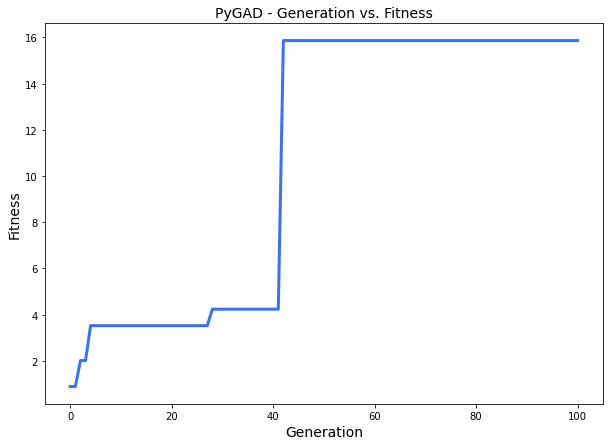

Parameters of the best solution : [0.174]
Fitness value of the best solution = 15.865268061107367
Index of the best solution : 0


In [103]:
# (5) GA results are plotted:
# After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
ga_instance.plot_result()
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

/opt/anaconda3/lib/python3.8/site-packages/pygad/pygad.py:3142: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


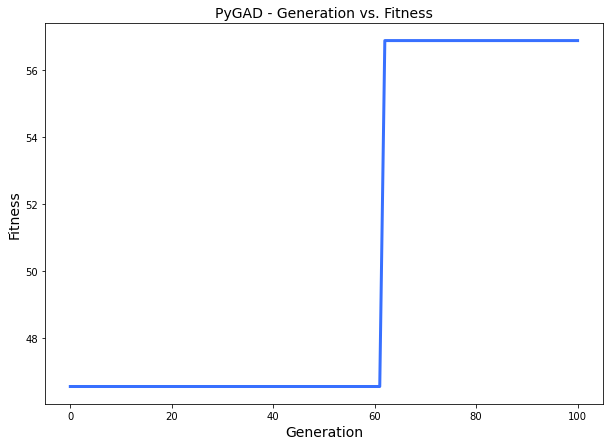

Parameters of the best solution : [0.001]
Fitness value of the best solution = 56.87485353766249
Index of the best solution : 0


In [123]:
# (5) GA results are plotted:
# After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
ga_instance.plot_result()
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

In [105]:

# (6) The solution is confirmed launching Epanet:
# Change a parameter value (demand at N8) and run the model again
junction = wn.get_node('N7')
junction.demand_timeseries_list[0].base_value = function_inputs*solution[0]
results = sim.run_sim()
# Get and print the new pressure
pressure = results.node['pressure']
pressure_at_N7 = pressure['N7'][0]
print(pressure_at_N7)

-561.6371


In [ ]:
# Data Generation from EPANET => 30 DAYS OBSERVATION
# Formular for estimating leakages in a network

**Project:** Optimizing Travel Itineraries With Machine Learning

**Presentation.** Presentation can be found [here](https://github.com/vlazovskiy/route-optimizer-machine-learning/blob/master/Itinerary%20Optimization%20With%20Machine%20Learning.pdf).

**Project goal.** The goal of my project is to optimize travel routes for a delivery vehicle by using machine learning model predictions. This is a two-component problem: first, I train a machine learning model on the data to predict how long it will take a delivery vehicle to go from point one point to another, and I feed these predictions into a genetic algorithm which decides which is the most time efficient visit order for a given set of points. 

Here is an illustration of my pipeline: data -> machine learning -> optimization with genetic algorithm

<img width="630" alt="screen shot 2018-04-12 at 2 03 39 am" src="https://user-images.githubusercontent.com/32041665/38667230-bec5a5e0-3df5-11e8-908d-4664963cb217.png">

**Data and Features.** New York City taxi data set was taken from [here](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml), with an additional New York City weather dataset obtained from [Kaggle](https://www.kaggle.com/cabaki/knycmetars2016).

**Models.** After doing a quick baselining with a basic linear regression on the main dataset I realized that a far more complex model was needed. To this end, I selected an XGBoost model to accommodate for my complex numeric and categorical features. I also used a LightGBM model when adding weather data because this package can handle categorical data and runs faster, but I used this model mostly for experimentation with features and did not include in my final pipeline.

**Optimization.** For any given set of locations, these location are fed to the machine learning model, which predicts how long it will take to travel between each two given points. Then the algorithm "evolves" to find the visit order which minimizes time spent in transit. 

**Results.** The XGBoost model had an error of 4.8 minutes in estimating a single trip's duration for a motor vehicle. While this may seem acceptable for one trip, the error may get bigger the more locations are visited. The genetic algorithm itself is fairly straightforward, but it must be noted that every genetic algorithm gives an optimal approximation, but not the single best solution there is.

**Acknowledgements.** Big thanks to [this notebook](https://github.com/ZWMiller/PythonProjects/blob/master/genetic_algorithms/evolutionary_algorithm_traveling_salesman.ipynb) for providing the code for the genetic algorithm and making it accessible.

**NOTE.** The original presentation contains a short video demo, which is unavailable in the pdf format.
